In [47]:
#imports 
import pandas as pd

In [48]:
# read in semi clean df
child = pd.read_csv('../data/semi_clean_df.csv')
# filter UNHAP42 to only 1-4
hap_filter =(child['UNHAP42'] == 0) | (child['UNHAP42'] == 1) | (child['UNHAP42'] == 2) | (child['UNHAP42'] == 3) | (child['UNHAP42'] == 4)
# set df equal to origin dataframe with above filter
df = child[hap_filter]
# create classes for UNHAP42 
df['UNHAP42'] = df['UNHAP42'].map({0:0, 1:1, 2:1, 3:1, 4:1})
# check class distribution
df['UNHAP42'].value_counts(normalize=True)

0    0.736149
1    0.263851
Name: UNHAP42, dtype: float64

#### Imports for modeling

In [60]:
# import logistic regression
from sklearn.linear_model import LogisticRegression

# import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# standard scaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

#impor numpy 
import numpy as np

# import Smote from imblearn
from collections import Counter
import imblearn
from imblearn.pipeline import Pipeline as PipeLine
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#### Using Smote to create random samples in an attempt to balance the classes.

In [50]:
# set X, y 
X = df.drop(columns='UNHAP42')
y = df['UNHAP42']

In [51]:
#TTS
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

In [52]:
# Create oversample object with Smote and reassign X_train, y_train
oversample = SMOTE(random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

In [53]:
# Only train is over sampled, below is a print out of the samples for each class
counter = Counter(y_train)
print(f'Training Targets:{counter}')
counter = Counter(y_test)
print(f'Testing Targets:{counter}')

Training Targets:Counter({0: 3269, 1: 3269})
Testing Targets:Counter({0: 1089, 1: 391})


#### Now we have a balance of classes for modeling thanks to smote.
#### Next step is to use our new train test split on default logistic regression.

In [54]:
# instantiate logistic regression
logreg = LogisticRegression()

In [55]:
# fit 
logreg.fit(X_train, y_train)

C:\Users\phill\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Logistic Regression Results

Train Score    :  0.8031508106454573
Test Score     :  0.8263513513513514
Accuracy Score :  0.8263513513513514
Recall Score   :  0.7595907928388747


              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1089
           1       0.65      0.76      0.70       391

    accuracy                           0.83      1480
   macro avg       0.78      0.80      0.79      1480
weighted avg       0.84      0.83      0.83      1480



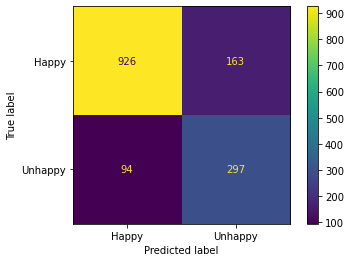

In [56]:
# output summary
print('Logistic Regression Results')
print('')
print('Train Score    : ', logreg.score(X_train, y_train))
print('Test Score     : ', logreg.score(X_test, y_test))
print('Accuracy Score : ', accuracy_score(y_test, logreg.predict(X_test)))
print('Recall Score   : ', recall_score(y_test, logreg.predict(X_test)))
print('')
# print and plot confusion matrix
cm = confusion_matrix(y_test, logreg.predict(X_test))
ConfusionMatrixDisplay(cm, display_labels=['Happy', 'Unhappy']).plot();
print('')
# print classification report
print(classification_report(y_test, logreg.predict(X_test)))

### Note:
Much better recall score up .152 from the previous default logistic regression.  Scores are down but still out performing the baseline.

#### The next step is a grid search for with the balanced train test split.

In [69]:
# define pipeline
pipe = PipeLine([
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [70]:
# define grid search params
params = {'sc__with_mean': [True, False],
          'sc__with_std' : [True, False],
          'logreg__C'          : np.linspace(0, 1, 5),
          'logreg__max_iter'   : [500,1000],
          'logreg__penalty'    : ['l1', 'l2'],
          'logreg__solver'     : ['liblinear'],
          'logreg__class_weight': [None, 'balanced']
}

In [71]:
# create grid
grid = GridSearchCV(pipe, params, cv=5)

In [72]:
# fit grid 
grid.fit(X_train, y_train)

C:\Users\phill\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\phill\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\phill\anaconda3\lib\site-packages\imblearn\pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\phill\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1358, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "C:\Users\phill\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 975, in _fit_liblinear
    raw_coef_, n_iter_ = liblinear.train_wrap(
  File "sklearn\svm\_liblinear.pyx", line 52, in sklearn.svm._liblinear.train_wrap
ValueError: b'C <= 0'

  warn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                         'logreg__class_weight': [None, 'balanced'],
                         'logreg__max_iter': [500, 1000],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear'],
                         'sc__with_mean': [True, False],
                         'sc__with_std': [True, False]})

Logistic Regression Results

Train Score    :  0.8020801468338942
Test Score     :  0.8324324324324325
Accuracy Score :  0.8324324324324325
Recall Score   :  0.7544757033248082


              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1089
           1       0.66      0.75      0.70       391

    accuracy                           0.83      1480
   macro avg       0.78      0.81      0.79      1480
weighted avg       0.84      0.83      0.84      1480



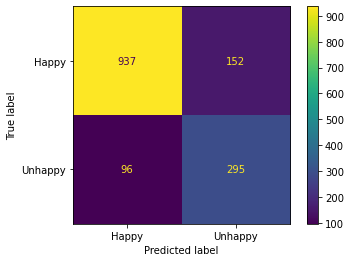

In [73]:
# create a summary of results from the grid search
print('Logistic Regression Results')
print('')
print('Train Score    : ', grid.score(X_train, y_train))
print('Test Score     : ', grid.score(X_test, y_test))
print('Accuracy Score : ', accuracy_score(y_test, grid.predict(X_test)))
print('Recall Score   : ', recall_score(y_test, grid.predict(X_test)))
print('')
# print and plot confusion matrix
cm = confusion_matrix(y_test, grid.predict(X_test))
ConfusionMatrixDisplay(cm, display_labels=['Happy', 'Unhappy']).plot();
print('')
# print classification report
print(classification_report(y_test, grid.predict(X_test)))

### Note:
This is the best recall score for logistic regression with scores still higher than the baseline.

#### Next step is to create a dataframe with coefficient values for each feature.

In [74]:
#Create logistic regression with best parameters from gridsearch
# Scale data
sc = StandardScaler(with_mean=False, with_std=False)
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
# create logreg 
logreg = LogisticRegression(C=.75, class_weight='balanced', max_iter=1000, penalty='l1', solver='liblinear')
# fit logreg with scaled data
logreg.fit(X_train_sc, y_train)

LogisticRegression(C=0.75, class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')

Logistic Regression Results

Train Score    :  0.8020801468338942
Test Score     :  0.8317567567567568
Accuracy Score :  0.8317567567567568
Recall Score   :  0.7570332480818415


              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1089
           1       0.66      0.76      0.70       391

    accuracy                           0.83      1480
   macro avg       0.78      0.81      0.79      1480
weighted avg       0.84      0.83      0.84      1480



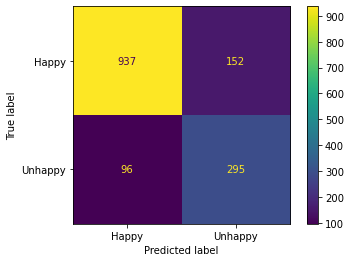

In [75]:
# create a summary of results from the grid search
print('Logistic Regression Results')
print('')
print('Train Score    : ', logreg.score(X_train, y_train))
print('Test Score     : ', logreg.score(X_test, y_test))
print('Accuracy Score : ', accuracy_score(y_test, logreg.predict(X_test)))
print('Recall Score   : ', recall_score(y_test, logreg.predict(X_test)))
print('')
# print and plot confusion matrix
cm = confusion_matrix(y_test, grid.predict(X_test))
ConfusionMatrixDisplay(cm, display_labels=['Happy', 'Unhappy']).plot();
print('')
# print classification report
print(classification_report(y_test, logreg.predict(X_test)))

In [76]:
# create coef dataframe
coef_df = pd.DataFrame(index=X_train.columns, data=logreg.coef_[0], columns=['Coefficient Value'])
# sort by coef value
coef_df.sort_values(by='Coefficient Value', inplace=True)

In [77]:
# output coef dataframe
coef_df.tail(5)

,Coefficient Value
CHLIMI42,0.453659
ADUPRO42,0.530486
HOMEBH42,0.666560
HAVFUN42,0.868686
NERVAF42,1.141399
